In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns
import scipy

from sklearn.metrics import mean_absolute_error

import glob, os

import scripts as scripts

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [59]:
!pwd

/lindorffgrp-isilon/maghoi/projects/ML-ddg-dde-variants


In [12]:
# Load data
dfs_analysis = pd.read_csv("data/merged_predictions.csv", index_col = 0)
dfs_analysis

,protein,variant,y_true,y_raw,y_pred,y_pred_binary,y_true_binary,wt,pos,mut,...,gemme_aa_p0_T,gemme_aa_p0_V,gemme_aa_p0_W,gemme_aa_p0_Y,gemme_aa_wt_p,gemme_M_p0,gemme_mean_aa,Rank_Class_s_norm_total,Rank_Class_s_orig,Rank_Class_s_norm
0,ccdB_DMS.csv,F3E,0.157895,-7.00,0.306174,0,0,F,3,E,...,0.876064,0.679787,0.543085,0.222340,0.807181,0.807181,0.561170,Low_Rank,Low_Rank,Low_Rank
1,ccdB_DMS.csv,F3H,1.000000,-2.00,0.418871,0,1,F,3,H,...,0.876064,0.679787,0.543085,0.222340,0.700532,0.807181,0.481383,High_Rank,High_Rank,High_Rank
2,ccdB_DMS.csv,F3I,0.223684,-6.00,0.427669,0,0,F,3,I,...,0.876064,0.679787,0.543085,0.222340,0.656915,0.807181,0.371809,Low_Rank,Low_Rank,Low_Rank
3,ccdB_DMS.csv,F3K,0.223684,-6.00,0.300255,0,0,F,3,K,...,0.876064,0.679787,0.543085,0.222340,0.846543,0.807181,0.605319,Low_Rank,Low_Rank,Low_Rank
4,ccdB_DMS.csv,F3L,0.105263,-8.00,0.555472,1,0,F,3,L,...,0.876064,0.679787,0.543085,0.222340,0.117553,0.807181,0.359043,Low_Rank,Low_Rank,Low_Rank
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154803,bla_DMS_d.csv,W286R,0.500000,-4.37,0.438075,0,1,W,286,R,...,0.076468,0.048393,101.000000,0.061692,0.107222,0.080163,0.579331,Middle_Rank,Middle_Rank,Middle_Rank
154804,bla_DMS_d.csv,W286S,0.748355,-1.26,0.483768,1,1,W,286,S,...,0.076468,0.048393,101.000000,0.061692,0.082194,0.080163,0.430920,High_Rank,High_Rank,High_Rank
154805,bla_DMS_d.csv,W286T,0.500000,-4.37,0.469582,1,1,W,286,T,...,0.076468,0.048393,101.000000,0.061692,0.076468,0.080163,0.441171,Middle_Rank,Middle_Rank,Middle_Rank
154806,bla_DMS_d.csv,W286V,0.952408,0.46,0.460113,0,1,W,286,V,...,0.076468,0.048393,101.000000,0.061692,0.048393,0.080163,0.452715,High_Rank,High_Rank,High_Rank


# Figure 1

In [18]:
df = dfs_analysis.copy()
df = df[df["rosetta_ddg_score"] <= 16]
df = df[df["rosetta_ddg_score"] >= -4]


### Experimental MAVE Fitness landscape

<ipython-input-19-1d9e599a2881>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fitness_landscape.pdf", bbox_tight = True)


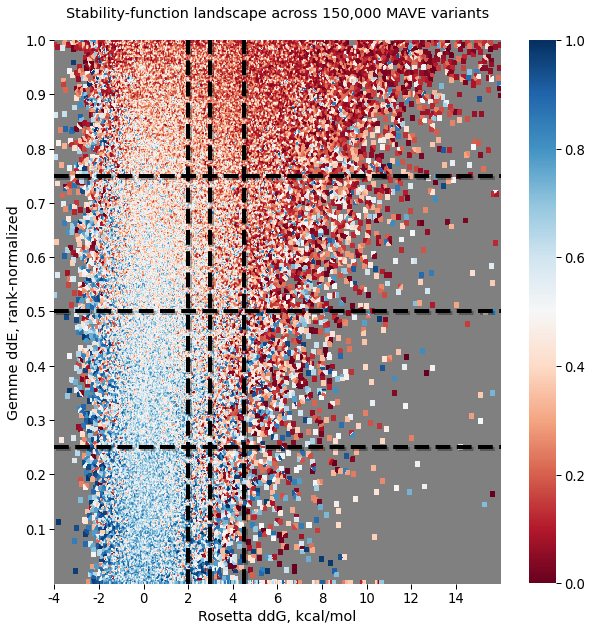

In [19]:
total_variants = str(len(df))
title = "Stability-function landscape across 150,000 MAVE variants\n"

# Plot settings
sns.set_context(context = "paper", font_scale = 1.5)

# Plot figure
scripts.gaussian_convolutional_heatmap(df["rosetta_ddg_score"], df["gemme_score"],
                               c = df["y_true"], conv_std = 1, cmap = "RdBu",
                              vmin = 0, vmax = 1)

plt.title(title)
plt.xlabel("Rosetta ddG, kcal/mol")
plt.ylabel("Gemme ddE, rank-normalized")

# Set lines at tickmarks
ticks = np.arange(0, 1000+1, int(1000 / 10))
labels = np.array(range(ticks.size))/10
labels2 = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16][::-1]
plt.xticks(ticks[: -1], labels2[::-1][: -1]) # Exclude first 0.0 to avoid overlap with x-axis labels

#Note: Changing threshold values from 1.95->2.0, 2.95->3.0, 4.47->4.5
plt.axvline(x = int( ((4+2.0)/20) * 1000 ), c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axvline(x = int( ((4+3.0)/20) * 1000 ), c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axvline(x = int( ((4+4.5)/20) * 1000 ), c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])

plt.axhline(y = 250, c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axhline(y = 500, c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axhline(y = 750, c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])

# Save figure
plt.savefig("figures/fitness_landscape.pdf", bbox_tight = True)


### Predicted MAVE Fitness landscape

<ipython-input-20-5d867e636108>:30: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("figures/fitness_landscape_predicted.pdf", bbox_tight = True)


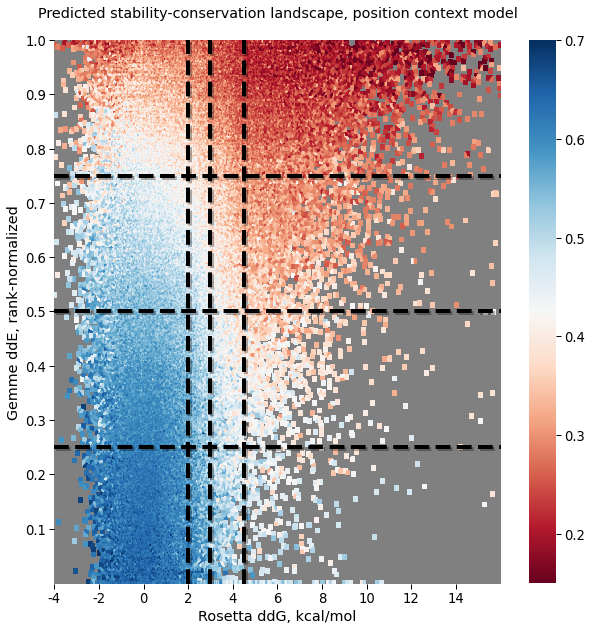

In [20]:
total_variants = str(len(df))
title = "Predicted stability-conservation landscape, position context model\n"

# Plot settings
sns.set_context(context = "paper", font_scale = 1.5)

# Plot figure
scripts.gaussian_convolutional_heatmap(df["rosetta_ddg_score"], df["gemme_score"], c = df["y_pred"], vmin = 0.15, vmax = 0.7, conv_std = 1, cmap = "RdBu")

plt.title(title)
plt.xlabel("Rosetta ddG, kcal/mol")
plt.ylabel("Gemme ddE, rank-normalized")

# Set lines at tickmarks
ticks = np.arange(0, 1000+1, int(1000 / 10))
labels = np.array(range(ticks.size))/10
labels2 = [-4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16][::-1]
plt.xticks(ticks[: -1], labels2[::-1][: -1]) # Exclude first 0.0 to avoid overlap with x-axis labels

#Note: Changing threshold values from 1.95->2.0, 2.95->3.0, 4.47->4.5
plt.axvline(x = int( ((4+2.0)/20) * 1000 ), c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axvline(x = int( ((4+3.0)/20) * 1000 ), c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axvline(x = int( ((4+4.5)/20) * 1000 ), c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])

plt.axhline(y = 250, c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axhline(y = 500, c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])
plt.axhline(y = 750, c = "black", linewidth = 4, linestyle = "--", path_effects=[pe.SimpleLineShadow(shadow_color='black'), pe.Normal()])

# Save figure
plt.savefig("figures/fitness_landscape_predicted.pdf", bbox_tight = True)

### Experimental MAVE fitness landscape, proportion of High/Low-rank variants

Returning 4 arrays:
    plot_array_proportion, plot_array_mae, plot_array_mae_ratio, plot_array_density
    


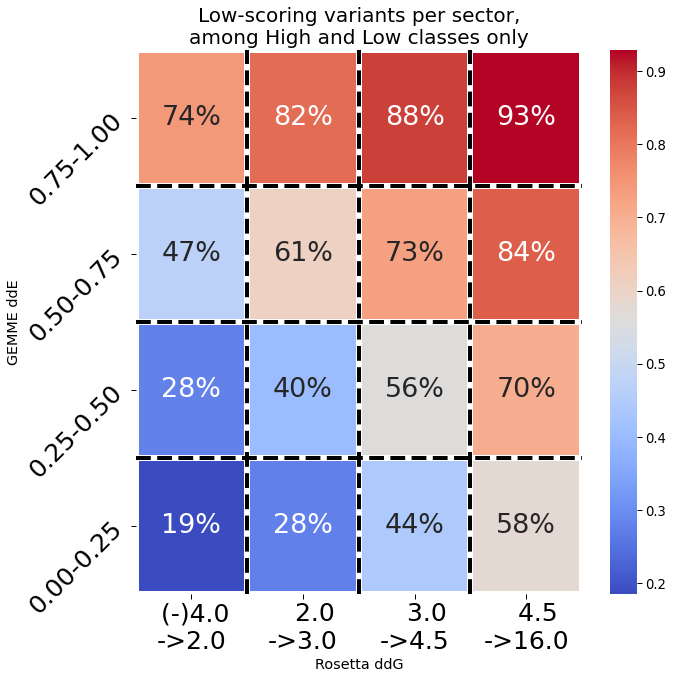

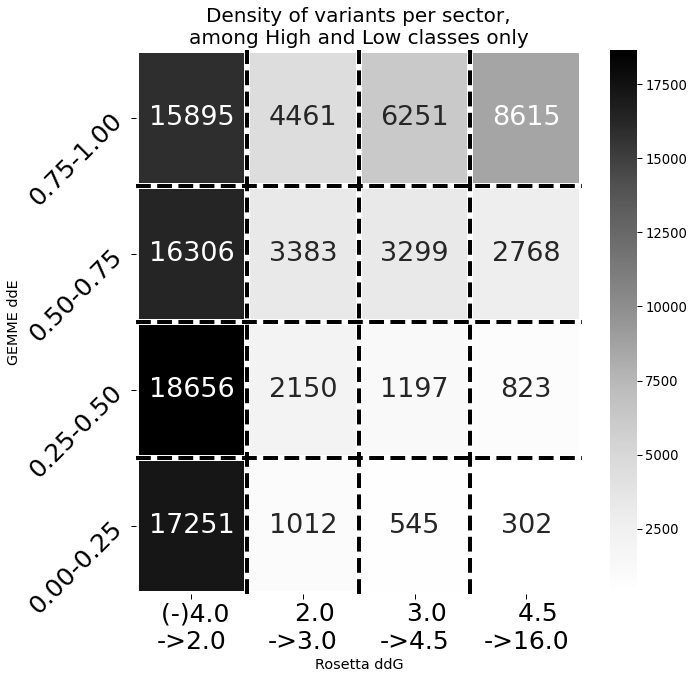

In [22]:
df = dfs_analysis.copy()
df = df[df["rosetta_ddg_score"] <= 16]
df = df[df["rosetta_ddg_score"] >= -4]

# Use top and bottom third of variants from each MAVE to define High and Low classes
df = df[df["Rank_Class_s_norm"].str.contains("High|Low")]

plot_array_proportion, plot_array_mae, plot_array_mae_ratio, plot_array_density = scripts.return_array_stats(df)

# Plot
scripts.plot_array_stats(plot_array_proportion, cmap = "coolwarm", fmt = ".0%")
plt.title("Low-scoring variants per sector,\namong High and Low classes only", size = 20)
plt.savefig("figures/fitness_landscape_lowfitness_proportion__3.pdf", bbox_inches = "tight")

scripts.plot_array_stats(plot_array_density, cmap = "Greys", fmt = ".0f")
plt.title("Density of variants per sector,\namong High and Low classes only", size = 20)
plt.savefig("figures/fitness_landscape_density_highlow__3.pdf", bbox_inches = "tight")



## Random Forest position-context model mean absolute error per ddG/ddE sector

Returning 4 arrays:
    plot_array_proportion, plot_array_mae, plot_array_mae_ratio, plot_array_density
    


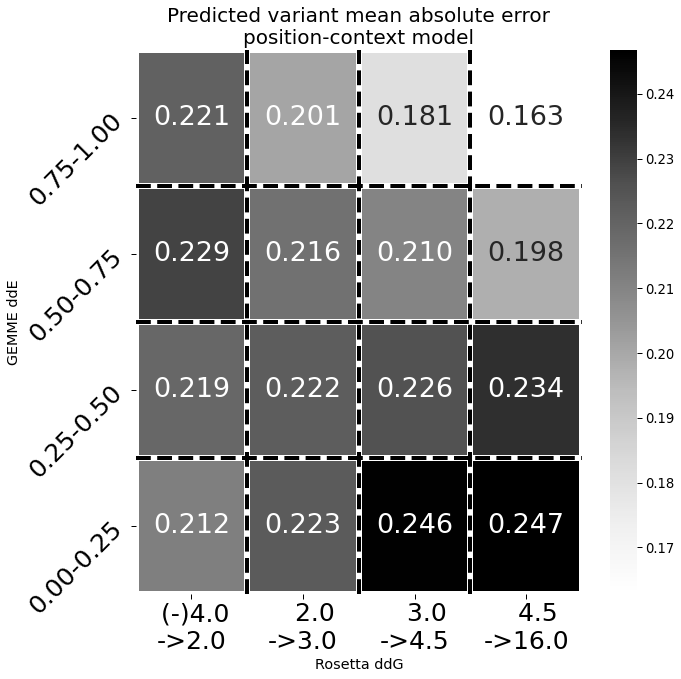

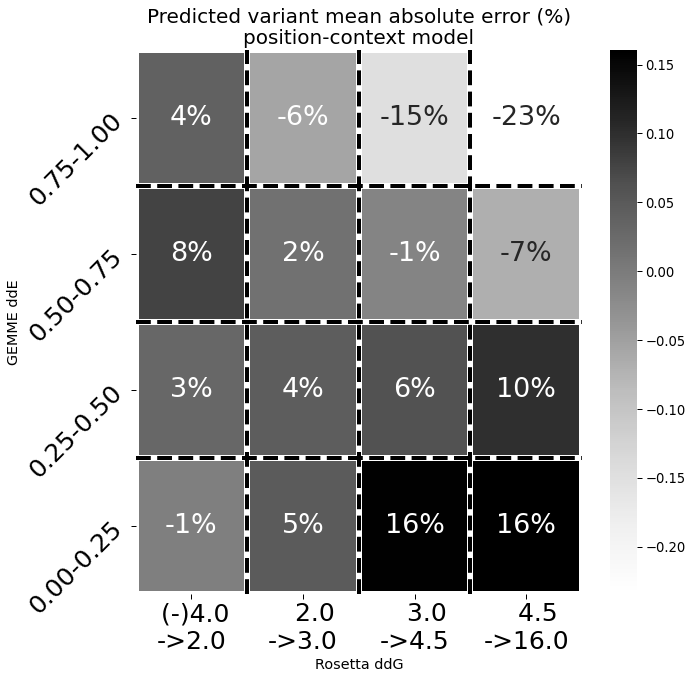

In [25]:
df = dfs_analysis.copy()
df = df[df["rosetta_ddg_score"] <= 16]
df = df[df["rosetta_ddg_score"] >= -4]

plot_array_proportion, plot_array_mae, plot_array_mae_ratio, plot_array_density = scripts.return_array_stats(df)

#Plot
scripts.plot_array_stats(plot_array_mae, cmap = "Greys", fmt = ".3f")
plt.title("Predicted variant mean absolute error\nposition-context model", size = 20)
plt.savefig("figures/fitness_landscape_predicted_MAE.pdf", bbox_inches = "tight")

scripts.plot_array_stats(plot_array_mae_ratio, cmap = "Greys", fmt = ".0%")
plt.title("Predicted variant mean absolute error (%)\nposition-context model", size = 20)
plt.savefig("figures/fitness_landscape_predicted_MAE_ratio.pdf", bbox_inches = "tight")

### Rosetta ddG, GEMME ddE distributions

In [26]:
sns.set_style("ticks")

df = dfs_analysis.copy()
df = df[df["rosetta_ddg_score"] <= 16]
df = df[df["rosetta_ddg_score"] >= -4]
df = df[df["Rank_Class_s_orig"].str.contains("High|Low")]

df_plot = df.copy()
df_plot["Variants"] = df_plot["Rank_Class_s_orig"].replace({"High_Rank" : "High fitness", "Low_Rank" : "Low fitness"})
df_plot["Variants_pred"] = df_plot["y_pred_binary"].replace({1 : "High fitness", 0 : "Low fitness"})

In [27]:
def print_feature_variant_threshold_stats(df, feature, thresholds, variant_col = "Variants",
                                          low_fitness_col = "Low fitness"):
    # Print ddE/ddG variant proportion statistics
    for i in range(len(thresholds) - 1):
        m = np.logical_and(df[feature] > thresholds[i], df[feature] <= thresholds[i + 1])
        p_total = np.round((np.sum(m) / len(m)*100), 3)
        p_lf = np.round( (np.sum(df[m][variant_col] == low_fitness_col) / len(df[m])*100), 3)
        print(thresholds[i], "<", feature, ">" , thresholds[i+1],
              "->", np.sum(m), "variants of", len(m), "total =", p_total, "%.", "Proportion low fitness =", p_lf, "%")

-4.01 < rosetta_ddg_score > 1.95 -> 67437 variants of 102914 total = 65.528 %. Proportion low fitness = 37.195 %
1.95 < rosetta_ddg_score > 2.95 -> 11234 variants of 102914 total = 10.916 %. Proportion low fitness = 58.216 %
2.95 < rosetta_ddg_score > 4.47 -> 11555 variants of 102914 total = 11.228 %. Proportion low fitness = 75.474 %
4.47 < rosetta_ddg_score > 16.01 -> 12688 variants of 102914 total = 12.329 %. Proportion low fitness = 86.814 %


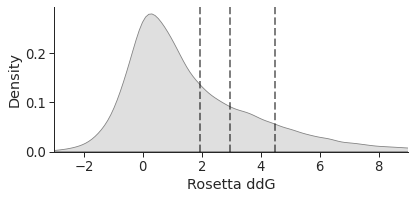

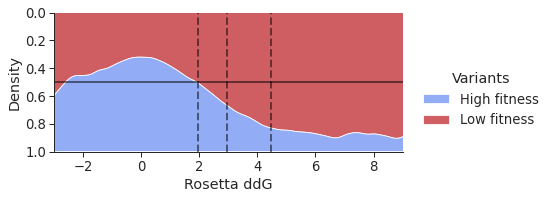

In [28]:
#####
# Rosetta distribution
#####

sns.displot(df_plot, x="rosetta_ddg_score", color = "gray", fill = True, kind="kde", height = 3, aspect = 2)

# Figure settings
plt.xlabel("Rosetta ddG")
plt.xlim(-3, 9)

# Lines
plt.axvline(x = 1.95, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 2.95, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 4.47, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)

# Save figure
#plt.savefig("figures/rosetta_distribution.pdf")


#####
# Rosetta variant proportion
#####

# Define color map
colors = list(sns.color_palette("coolwarm", n_colors = 30))
color_list = [colors[4], colors[-1]]
cmap = sns.color_palette(color_list, n_colors = 2)

# Plot figure
sns.displot(df_plot, x="rosetta_ddg_score", palette = cmap, hue="Variants", kind="kde", multiple = "fill", height = 3, aspect = 2, hue_order = ["High fitness", "Low fitness"])

# Figure settings
plt.xlabel("Rosetta ddG")
plt.xlim(-3, 9)
plt.ylim(reversed(plt.ylim()))

# Lines
plt.axvline(x = 1.95, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 2.95, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 4.47, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axhline(y = 0.5, c = "black", linewidth = 2, linestyle = "-", alpha = 0.5)

# Print ddG variant proportion statistics
print_feature_variant_threshold_stats(df_plot, "rosetta_ddg_score", thresholds = [-4.01, 1.95, 2.95, 4.47, 16.01])
    
# Save figure
plt.savefig("figures/rosetta_variant_distribution.pdf")

-0.01 < gemme_score > 0.25 -> 19116 variants of 102914 total = 18.575 %. Proportion low fitness = 16.829 %
0.25 < gemme_score > 0.5 -> 22834 variants of 102914 total = 22.187 %. Proportion low fitness = 28.138 %
0.5 < gemme_score > 0.75 -> 25746 variants of 102914 total = 25.017 %. Proportion low fitness = 52.711 %
0.75 < gemme_score > 1.01 -> 35218 variants of 102914 total = 34.221 %. Proportion low fitness = 79.919 %


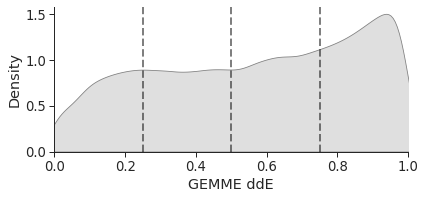

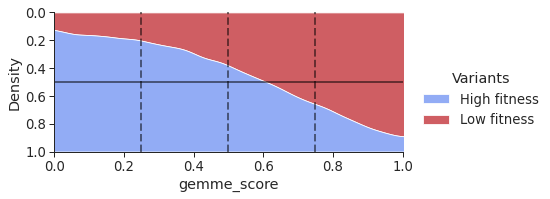

In [29]:
#####
# GEMME distribution
#####

# Plot figure
sns.displot(df_plot, x="gemme_score", color = "gray", fill = True, kind="kde", height = 3, aspect = 2)

# Figure settings
plt.xlabel("GEMME ddE")
plt.xlim(0, 1)

# Lines
plt.axvline(x = 0.75, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 0.50, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 0.25, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)

# Save figure
plt.savefig("figures/gemme_distribution.pdf")


#####
# GEMME variant proportion
#####

# Define color map
colors = list(sns.color_palette("coolwarm", n_colors = 30))
color_list = [colors[4], colors[-1]]
cmap = sns.color_palette(color_list, n_colors = 2)

sns.displot(df_plot, x="gemme_score", palette = cmap, hue="Variants", kind="kde", multiple = "fill", height = 3, aspect = 2, hue_order = ["High fitness", "Low fitness"])

# Figure settings
plt.xlim(0, 1)
plt.ylim(reversed(plt.ylim()))

# Lines
plt.axvline(x = 0.25, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 0.50, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axvline(x = 0.75, c = "black", linewidth = 2, linestyle = "--", alpha = 0.5)
plt.axhline(y = 0.5, c = "black", linewidth = 2, linestyle = "-", alpha = 0.5)

# Print ddE variant proportion statistics
print_feature_variant_threshold_stats(df_plot, "gemme_score", thresholds = [-0.01, 0.25, 0.50, 0.75, 1.01])
    

# Save figure
plt.savefig("figures/gemme_variant_distribution.pdf")

### Random Forest Position-context model prediction density plot

In [30]:
df = dfs_analysis.copy()
spearman_r = np.round(df[["y_true", "y_pred"]].corr(method = "spearman").loc["y_true", "y_pred"], 3)
print("Spearman r predicted vs true:", spearman_r)

Spearman r predicted vs true: 0.497


/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/lindorffgrp-isilon/maghoi/_conda_env/envs/py37/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


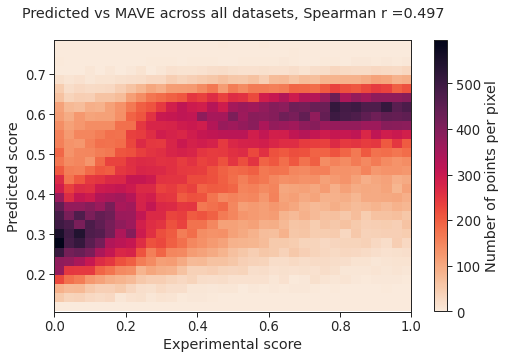

In [35]:
df = dfs_analysis.copy()

from mpl_scatter_density import *
def using_mpl_scatter_density(fig, x, y, dpi):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, dpi=dpi, cmap="rocket_r")
    fig.colorbar(density, label='Number of points per pixel')

fig = plt.figure(figsize = (8,5))
fig = using_mpl_scatter_density(fig, df["y_true"], df["y_pred"], dpi = 8)
plt.title("Predicted vs MAVE across all datasets, Spearman r =" + str(spearman_r) + "\n")
plt.ylabel("Predicted score")
plt.xlabel("Experimental score")
plt.savefig("figures/predicted_vs_mave_scatterplot.pdf")

### Feature importance dendrogram

In [42]:
dfs_analysis.columns

Index(['protein', 'variant', 'y_true', 'y_raw', 'y_pred', 'y_pred_binary',
       'y_true_binary', 'wt', 'pos', 'mut', 'ss', 'rsa', 'gemme_score',
       'rosetta_ddg_score', 'mave_wt_to_mut', 'mave_wt_to_any',
       'mave_any_to_mut', 'ros_aa_p0_A', 'ros_aa_p0_C', 'ros_aa_p0_D',
       'ros_aa_p0_E', 'ros_aa_p0_F', 'ros_aa_p0_G', 'ros_aa_p0_H',
       'ros_aa_p0_I', 'ros_aa_p0_K', 'ros_aa_p0_L', 'ros_aa_p0_M',
       'ros_aa_p0_N', 'ros_aa_p0_P', 'ros_aa_p0_Q', 'ros_aa_p0_R',
       'ros_aa_p0_S', 'ros_aa_p0_T', 'ros_aa_p0_V', 'ros_aa_p0_W',
       'ros_aa_p0_Y', 'ros_aa_wt_p', 'ros_M_p0', 'ros_mean_aa',
       'gemme_aa_p0_A', 'gemme_aa_p0_C', 'gemme_aa_p0_D', 'gemme_aa_p0_E',
       'gemme_aa_p0_F', 'gemme_aa_p0_G', 'gemme_aa_p0_H', 'gemme_aa_p0_I',
       'gemme_aa_p0_K', 'gemme_aa_p0_L', 'gemme_aa_p0_M', 'gemme_aa_p0_N',
       'gemme_aa_p0_P', 'gemme_aa_p0_Q', 'gemme_aa_p0_R', 'gemme_aa_p0_S',
       'gemme_aa_p0_T', 'gemme_aa_p0_V', 'gemme_aa_p0_W', 'gemme_aa_p0_Y',
       'gem

In [43]:
# Define training data
mask = dfs_analysis.columns.str.contains("gemme_score|gemme_aa_p0|gemme_M|rosetta_ddg_score|ros_aa_p0|ros_aa_M|mave")

# Choose high number
features_chosen = dfs_analysis.iloc[0:1000].columns[mask]

train_X = dfs_analysis[features_chosen]
train_y = dfs_analysis["y_true"]

print("Training features:", features_chosen)

Training features: Index(['gemme_score', 'rosetta_ddg_score', 'mave_wt_to_mut', 'mave_wt_to_any',
       'mave_any_to_mut', 'ros_aa_p0_A', 'ros_aa_p0_C', 'ros_aa_p0_D',
       'ros_aa_p0_E', 'ros_aa_p0_F', 'ros_aa_p0_G', 'ros_aa_p0_H',
       'ros_aa_p0_I', 'ros_aa_p0_K', 'ros_aa_p0_L', 'ros_aa_p0_M',
       'ros_aa_p0_N', 'ros_aa_p0_P', 'ros_aa_p0_Q', 'ros_aa_p0_R',
       'ros_aa_p0_S', 'ros_aa_p0_T', 'ros_aa_p0_V', 'ros_aa_p0_W',
       'ros_aa_p0_Y', 'gemme_aa_p0_A', 'gemme_aa_p0_C', 'gemme_aa_p0_D',
       'gemme_aa_p0_E', 'gemme_aa_p0_F', 'gemme_aa_p0_G', 'gemme_aa_p0_H',
       'gemme_aa_p0_I', 'gemme_aa_p0_K', 'gemme_aa_p0_L', 'gemme_aa_p0_M',
       'gemme_aa_p0_N', 'gemme_aa_p0_P', 'gemme_aa_p0_Q', 'gemme_aa_p0_R',
       'gemme_aa_p0_S', 'gemme_aa_p0_T', 'gemme_aa_p0_V', 'gemme_aa_p0_W',
       'gemme_aa_p0_Y', 'gemme_M_p0'],
      dtype='object')


In [44]:
# Load or train new model
filepath = "data/RF_position_context.joblib"

from sklearn.ensemble import RandomForestRegressor
from joblib import dump, load
if glob.glob(filepath):
    print("Loading existing model from", filepath)
    model = load(filepath)
else:
    print("Existing model not found. Training new and saving to", filepath)
    model = model.fit(train_X, train_y)
    dump(model, filepath)
    
print("\nModel parameters:\n", model.get_params(), sep = "")

Existing model not found. Training new and saving to data/RF_position_context.joblib

Model parameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 15, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


              Feature  Importance
0         gemme_score    0.150319
1       gemme_aa_p0_R    0.067650
2      mave_wt_to_mut    0.061380
3   rosetta_ddg_score    0.043774
4          gemme_M_p0    0.039763
5       gemme_aa_p0_Q    0.037386
6       gemme_aa_p0_H    0.036329
7       gemme_aa_p0_A    0.026787
8       gemme_aa_p0_N    0.025596
9       gemme_aa_p0_Y    0.024719
10      gemme_aa_p0_C    0.021736
11      gemme_aa_p0_S    0.021355
12      gemme_aa_p0_K    0.021070
13      gemme_aa_p0_P    0.017334
14      gemme_aa_p0_G    0.017137
15    mave_any_to_mut    0.016680
16      gemme_aa_p0_D    0.015987
17      gemme_aa_p0_W    0.015789
18      gemme_aa_p0_M    0.015432
19      gemme_aa_p0_E    0.014799
20        ros_aa_p0_R    0.013861
21      gemme_aa_p0_F    0.013557
22      gemme_aa_p0_I    0.013517
23      gemme_aa_p0_T    0.013395
24        ros_aa_p0_P    0.013283
25        ros_aa_p0_W    0.013122
26        ros_aa_p0_K    0.013049
27      gemme_aa_p0_L    0.012636
28        ros_

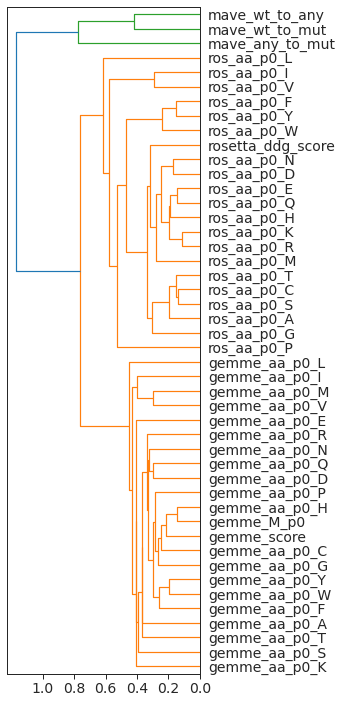

In [46]:
# Feature importance and co-correlation dendrogram
features = train_X.columns
training_data = train_X

from scipy.cluster import hierarchy as hc
from matplotlib import rc

#Plot
plt.rcParams['axes.grid'] = False
corr = np.round(scipy.stats.spearmanr(training_data).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average', optimal_ordering=True)
fig = plt.figure(figsize=(5,10))
dendrogram = hc.dendrogram(z, labels=features, 
      orientation='left', leaf_font_size=12)

# Ticks
plt.xticks(np.arange(0, 1.01, step=0.2), rotation =  0)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()



# Print feature importance
idxs = np.argsort(model.feature_importances_)[::-1]
df_features = pd.DataFrame({"Feature": features[idxs],
                   "Importance": model.feature_importances_[idxs]})
print(df_features)

# Save figure and feature importance
plt.savefig("figures/feature_dendrogram.pdf")
df_features.to_csv("data/feature_importance.csv")

### Random Forest position-context model partial dependence

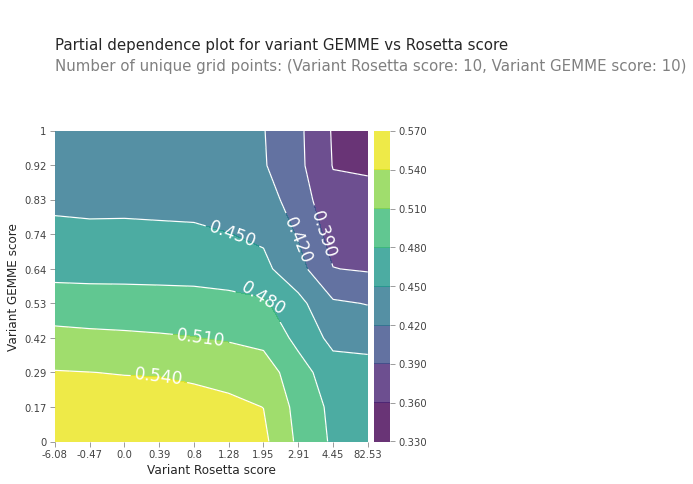

In [48]:
# Plots partial dependence of trained model for Rosetta ddG and GEMME ddE scores

# Set partial_samples to len(training_data) to get more accurate feature effect sampling
partial_samples = 2000
#partial_samples = len(training_data)

# PDPbox
from pdpbox import pdp, get_dataset, info_plots

inter_rf = pdp.pdp_interact(
    model=model, dataset=training_data.sample(n = partial_samples), model_features=features, 
    features=['rosetta_ddg_score', 'gemme_score']
)

fig, axes = pdp.pdp_interact_plot(
    inter_rf, ['Variant Rosetta score', 'Variant GEMME score'], x_quantile=True, plot_type='contour', plot_pdp=False,
    figsize = (6,8), plot_params = {"title":"Partial dependence plot for variant GEMME vs Rosetta score",
"inter_fontsize":17, "subtitle_fontsize":15}
)
plt.tight_layout()

# Save figure
plt.savefig("figures/partial_dependence.pdf")


## Feature UMAPs

In [54]:
# Calculate UMAP embeddings for features in MAVE positions with > 15 scores
#features = ["protein", "variant", "pos", "y_true", "y_pred",
#            "gemme_score", "rosetta_ddg_score", "mave_wt_to_mut", "rsa"]
df_analysis_filtered = dfs_analysis

In [55]:
dfs = [dfs_analysis[dfs_analysis["protein"] == protein] for protein in dfs_analysis["protein"].unique()]

In [56]:
# Quantile transform Rosetta
from sklearn.preprocessing import QuantileTransformer
print("Rank-normalizing Rosetta ddGs, rsa, mave_wt_to_mut before UMAPing")
for i in range(len(dfs)):
    qt = QuantileTransformer(n_quantiles=len(dfs[i]))
    dfs[i]["rosetta_ddg_score"] = qt.fit_transform(dfs[i][["rosetta_ddg_score"]])
    dfs[i]["rsa"] = qt.fit_transform(dfs[i][["rsa"]])
    dfs[i]["mave_p0"] = qt.fit_transform(dfs[i][["mave_wt_to_mut"]])

Rank-normalizing Rosetta ddGs, rsa, mave_wt_to_mut before UMAPing


In [57]:
# NB: May take 2-5 minutes

data_mave = scripts.extract_positions_from_seqmaps(dfs, extract_col = "y_true", missing_value = np.nan)
data_preds =  scripts.extract_positions_from_seqmaps(dfs, extract_col = "y_pred", missing_value = np.nan)
data_ros =  scripts.extract_positions_from_seqmaps(dfs, extract_col = "rosetta_ddg_score", missing_value = np.nan)
data_gem =  scripts.extract_positions_from_seqmaps(dfs, extract_col = "gemme_score", missing_value =  np.nan)
data_rsa =  scripts.extract_positions_from_seqmaps(dfs, extract_col = "rsa", missing_value = np.nan)
data_mave_variant_mean =  scripts.extract_positions_from_seqmaps(dfs, extract_col = "mave_wt_to_mut", missing_value = np.nan)

# PCA + UMAP, Beltrao protocol
# https://doi.org/10.1101/2020.05.26.116756

print("Generating UMAP embeddings ...")
data = pd.DataFrame(np.hstack([np.vstack(data_n) for data_n in [data_mave, data_ros, data_gem]]))
data = data.replace(101, np.nan)
data_labels = np.vstack(data_mave)

from sklearn.impute import SimpleImputer
transformer = SimpleImputer(missing_values=np.nan, strategy='mean')
data_imputed = transformer.fit_transform(data)

data_PCA = np.array(scripts.PCA_analysis(data_imputed, n_components = 20))

#print("Generating UMAP without PCA reduction")
print("Generating UMAP embeddings with default settings")
import umap
clusterable_embedding = umap.UMAP(
    random_state=42).fit_transform(data_PCA)

# Save
df_umap = pd.DataFrame({"UMAP1": clusterable_embedding[:, 0], "UMAP2": clusterable_embedding[:, 1]})
df_umap["MAVE"] = np.nanmean(data_mave, axis = 1)
df_umap["Predicted"] = np.nanmean(data_preds, axis = 1)
df_umap["Rosetta"] = np.nanmean(data_ros, axis = 1)
df_umap["Gemme"] = np.nanmean(data_gem, axis = 1)
df_umap["RSA"] = np.nanmean(data_rsa, axis = 1)
df_umap["MAVE_matrix"] = np.nanmean(data_mave_variant_mean, axis = 1)

# Fixes
df_umap = df_umap[~(np.isnan(df_umap["Gemme"]))]
df_umap = df_umap[~(np.isnan(df_umap["Rosetta"]))]
print("Note: Rosetta is rank-normalized and f(x) = 1-x")
df_umap["Rosetta"] = 1- df_umap["Rosetta"]

# Save
df_umap.to_csv("data/df_umap.csv", index = False)
df_umap.describe()


Generating UMAP embeddings ...
The top 20 principal components explain 86.72  % of the variance
Generating UMAP embeddings with default settings
Note: Rosetta is rank-normalized and f(x) = 1-x


,UMAP1,UMAP2,MAVE,Predicted,Rosetta,Gemme,RSA,MAVE_matrix
count,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6504.000000,6348.000000,6504.000000
mean,5.350100,5.721841,0.449246,0.460701,0.500682,0.570121,0.486449,0.500955
std,2.982703,2.340654,0.187830,0.111296,0.224516,0.236404,0.307810,0.054603
min,-0.562898,0.496782,0.000000,0.144634,0.009357,0.000000,0.000000,0.399535
25%,2.817416,4.002201,0.304539,0.370211,0.297453,0.391533,0.250605,0.451113
50%,5.262460,5.788088,0.461676,0.459074,0.521537,0.596434,0.500954,0.505912
75%,7.812624,7.502261,0.585400,0.562568,0.696339,0.758297,0.749486,0.544768
max,10.917323,10.509136,0.991659,0.744336,0.989108,0.996503,1.000000,0.592668


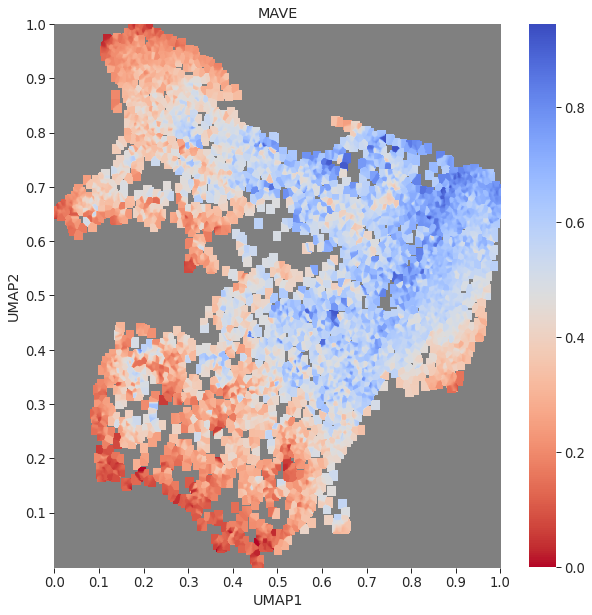

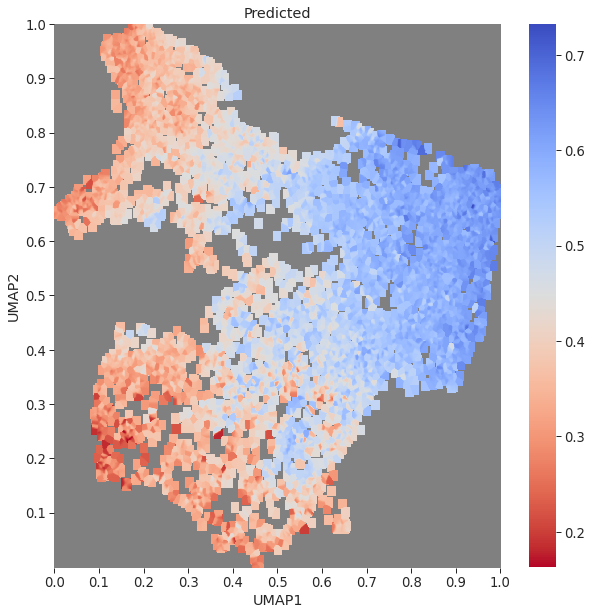

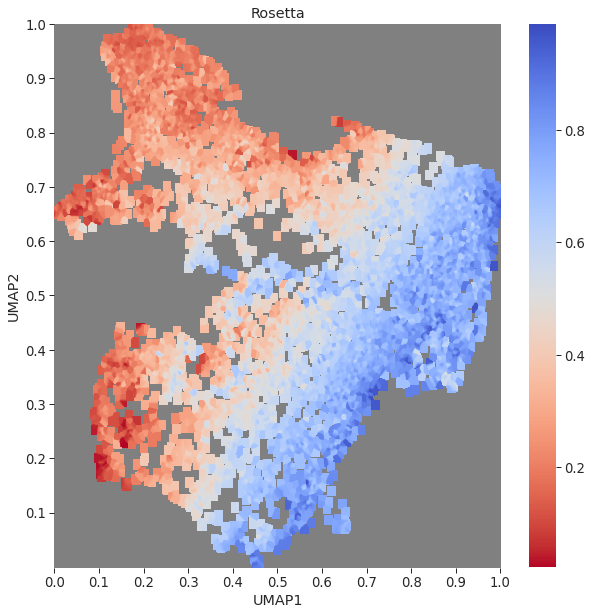

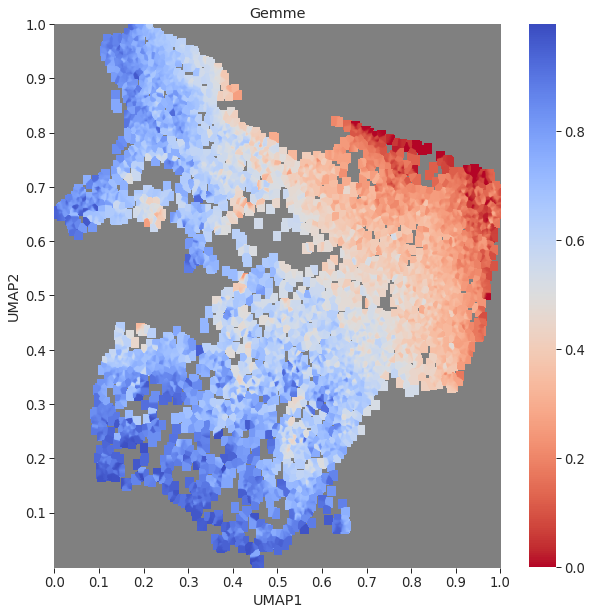

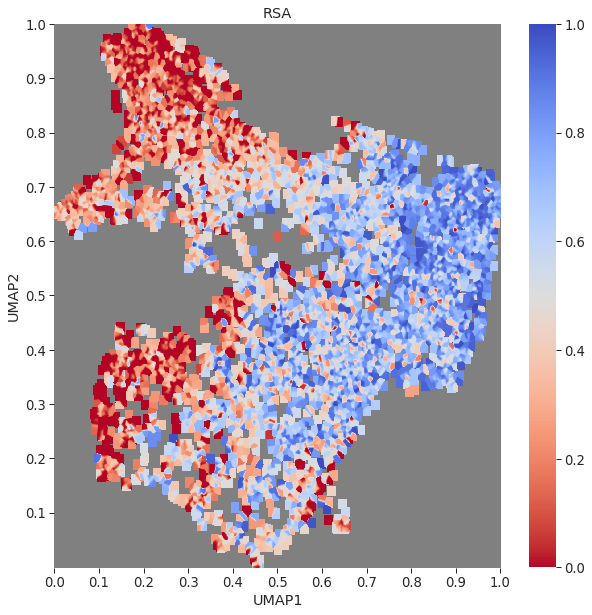

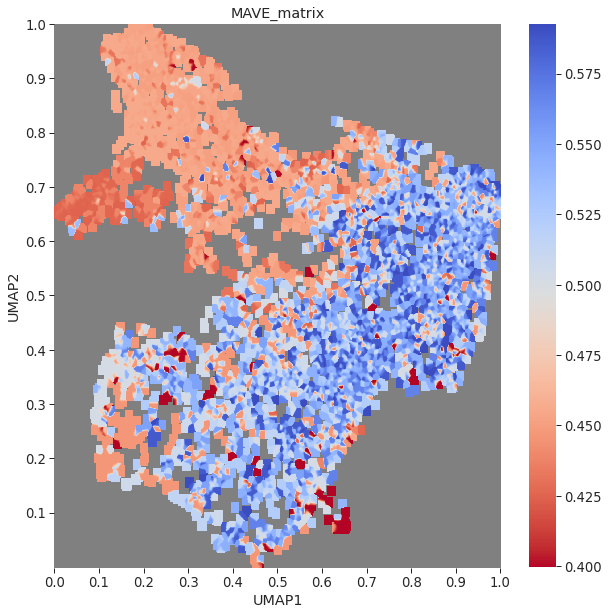

In [58]:
for feature in df_umap.columns[2:]:
    scripts.gaussian_convolutional_heatmap(df_umap["UMAP1"], df_umap["UMAP2"], c = df_umap[feature], conv_std=2)
    plt.title(feature)
    plt.savefig("figures/UMAP__" + str(feature) + ".pdf")